# LCLUC Random Forest Pre-Processing

In [1]:
# Import packages
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rioxr
import xarray as xr
import rasterstats
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', None)


In [2]:
# Read in data
wrk_dir = Path.cwd().parent # go up a directory with parent
data_path = os.path.join(wrk_dir, 'data')

# Rasters
s30 = rioxr.open_rasterio(os.path.join(data_path, 'S30_2022_median.tif'))
l30 = rioxr.open_rasterio(os.path.join(data_path, 'L30_2022_median.tif'))
dem = rioxr.open_rasterio(os.path.join(data_path, 'dem.tif'))
glcm_red = rioxr.open_rasterio(os.path.join(data_path, 'S30_2022_glcm_red.tif'))
glcm_nir = rioxr.open_rasterio(os.path.join(data_path, 'S30_2022_glcm_NIR_narrow.tif'))
s1 = rioxr.open_rasterio(os.path.join(data_path, 's1_2022_test.tif'))

# Shapefiles
labels = gpd.read_file(os.path.join(data_path, 'all_labels.shp'))
roi = gpd.read_file(os.path.join(data_path, 'ynd_test_buffer.shp'))

In [3]:
# Reproject region of interest to match labels
roi = roi.to_crs('EPSG:4326')
assert roi.crs == labels.crs

In [4]:
# Clip labelled data to ROI
labels_clip = gpd.clip(labels, roi)

In [5]:
# Function to rename bands using long_name attributes
def rename_bands_by_longname(xr_data):
    """Rename band coordinates to use long_name attributes"""
    # Get the tuple of all band names from any band's attributes
    all_band_names = xr_data.isel(band=0).attrs.get('long_name')
    
    if isinstance(all_band_names, tuple):
        # The long_name is a tuple with all band names
        new_band_names = list(all_band_names)
    else:
        # Fallback if structure is different
        new_band_names = [f'band_{i+1}' for i in range(len(xr_data.band))]
    
    # Direct coordinate replacement
    xr_data = xr_data.copy()
    xr_data['band'] = new_band_names
    return xr_data

# Rename bands for all raster datasets
s30 = rename_bands_by_longname(s30)
l30 = rename_bands_by_longname(l30)
glcm_red = rename_bands_by_longname(glcm_red)
glcm_nir = rename_bands_by_longname(glcm_nir)
s1 = rename_bands_by_longname(s1)

In [6]:
# Calculate EVI 
evi_s30 = 2.5 * ((s30.sel(band='NIR_narrow') - s30.sel(band='red')) / 
                 (s30.sel(band='NIR_narrow') + 6 * s30.sel(band='red') - 7.5 * s30.sel(band='blue') + 1))

evi_l30 = 2.5 * ((l30.sel(band='NIR_narrow') - l30.sel(band='red')) / 
                 (l30.sel(band='NIR_narrow') + 6 * l30.sel(band='red') - 7.5 * l30.sel(band='blue') + 1))

# Limit values with clip
evi_s30 = evi_s30.clip(min=-1, max=1)
evi_l30 = evi_l30.clip(min=-1, max=1)

In [7]:
# Rename EVI layers (convert to DataArrays with names)
evi_s30.name = 'evi_s30'
evi_l30.name = 'evi_l30'

# Add band dimension with a name
evi_s30 = evi_s30.expand_dims(band=['blue_evi_s30'])
evi_l30 = evi_l30.expand_dims(band=['blue_evi_l30'])

In [8]:
# GLCM names
glcm_names = ['GLCM_mean', 'GLCM_variance', 'GLCM_homogeneity', 'GLCM_contrast', 
              'GLCM_dissimilarity', 'GLCM_entropy', 'GLCM_second_moment', 'GLCM_correlation']

# Rename GLCM bands with suffixes
glcm_nir['band'] = [f"{name}_nir" for name in glcm_names]
glcm_red['band'] = [f"{name}_red" for name in glcm_names]

# Update HLS band names with suffixes
s30['band'] = [f"{band}_S30" for band in s30.band.values]
l30['band'] = [f"{band}_L30" for band in l30.band.values]

In [9]:
# Reproject all rasters to match roi extent and resolution
def reproject_match(source, match):
    """Reproject source raster to match the shape and projection of match raster"""
    return source.rio.reproject_match(match)

# Reproject everything to match s30
l30_aligned = reproject_match(l30, s30)
evi_s30_aligned = reproject_match(evi_s30, s30)
evi_l30_aligned = reproject_match(evi_l30, s30)
s1_aligned = reproject_match(s1, s30)
dem_aligned = reproject_match(dem, s30)
glcm_red_aligned = reproject_match(glcm_red, s30)
glcm_nir_aligned = reproject_match(glcm_nir, s30)


In [10]:
# Clip to ROI
roi_bounds = roi.total_bounds  # [minx, miny, maxx, maxy]
s30_clipped = s30.rio.clip_box(*roi_bounds)

In [11]:
# Convert band coordinates to strings for datasets that don't have string names
if not all(isinstance(b, str) for b in dem_aligned.band.values):
    dem_aligned = dem_aligned.assign_coords(band=[f'dem_band_{i}' for i in range(len(dem_aligned.band))])

if not all(isinstance(b, str) for b in s1_aligned.band.values):
    s1_aligned = s1_aligned.assign_coords(band=[f's1_band_{i}' for i in range(len(s1_aligned.band))])

# Now merge all bands into single dataset
rasters = xr.concat([
    l30_aligned,
    s30_clipped, 
    evi_l30_aligned,
    evi_s30_aligned,
    s1_aligned,
    dem_aligned,
    glcm_red_aligned,
    glcm_nir_aligned
], dim='band')


/Users/hayleeoyler/miniforge3/envs/ml-env/lib/python3.10/site-packages/matplotlib/image.py:500: RuntimeWarning: overflow encountered in divide
  vrange /= ((a_max - a_min) / frac)
/Users/hayleeoyler/miniforge3/envs/ml-env/lib/python3.10/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/Users/hayleeoyler/miniforge3/envs/ml-env/lib/python3.10/site-packages/matplotlib/image.py:493: RuntimeWarning: overflow encountered in subtract
  vrange -= a_min


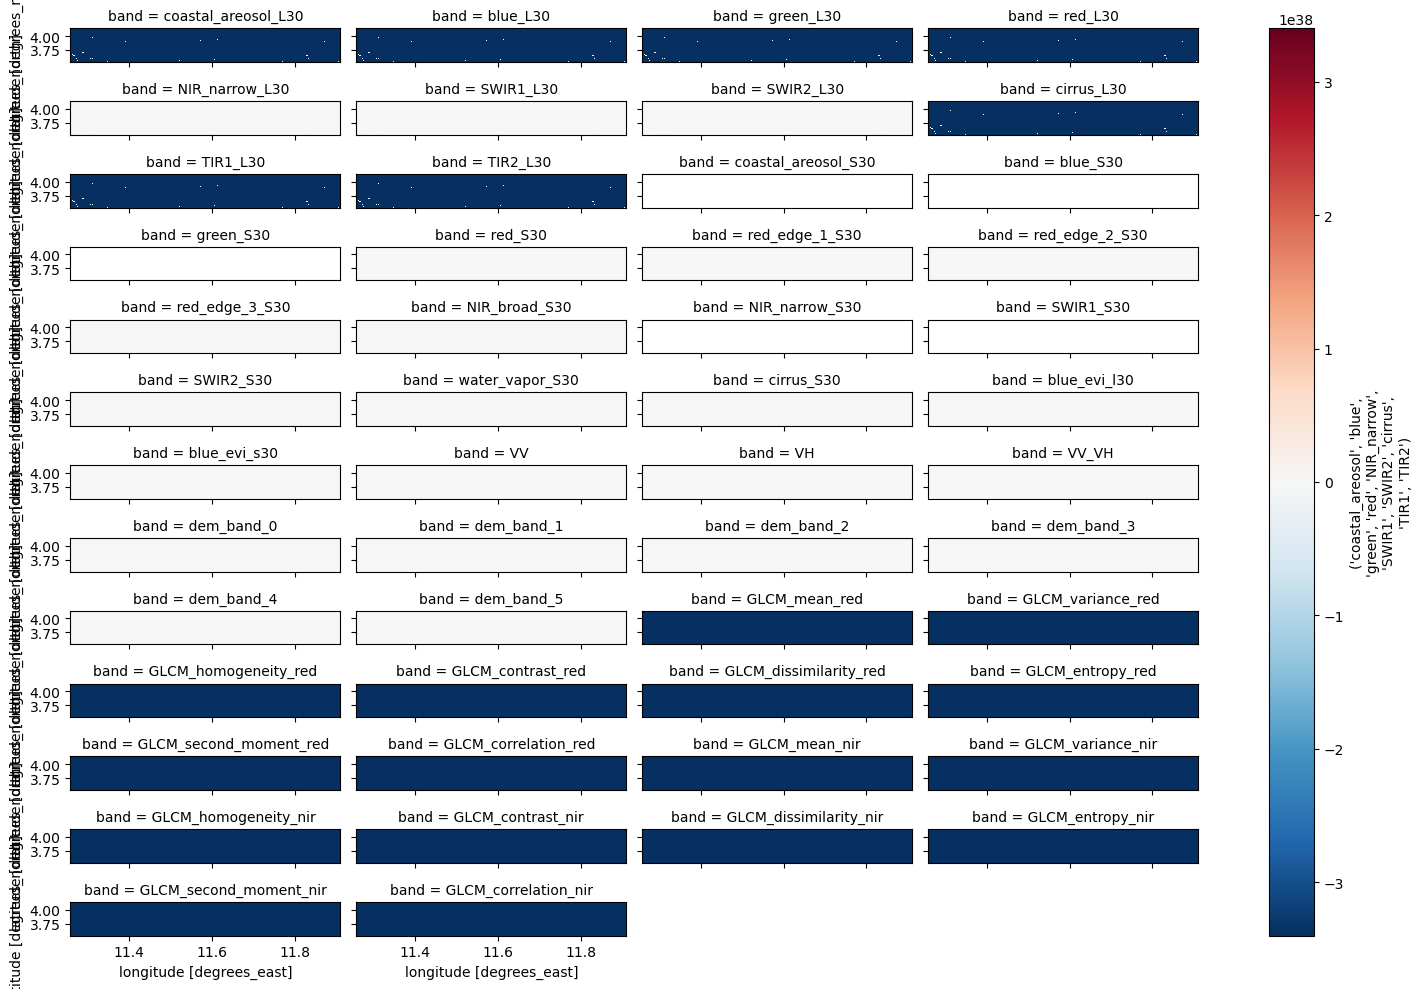

In [12]:
# Plot all bands
rasters.plot.imshow(col='band', col_wrap=4, figsize=(15, 10))
plt.show()


In [14]:
# Save the raster stack
rasters.to_netcdf(
    os.path.join(data_path, 'rasters_stack.nc'),
    encoding={
        'band': {'dtype': 'str'},  # Preserve band names
        '__xarray_dataarray_variable__': {
            'zlib': True,           # Enable compression
            'complevel': 4          # Compression level (1-9)
        }
    }
)

print(f"Saved raster stack to: {os.path.join(data_path, 'rasters_stack.nc')}")

Saved raster stack to: /Users/hayleeoyler/Hannah/LCLUC/data/rasters_stack.nc


In [ ]:
# For regular tif 
# rasters.rio.to_raster(os.path.join(data_path, 'rasters_stack.tif'), compress='lzw') 

In [13]:
# Convert labels to proper format if needed
labels_df = labels_clip.copy()

# Extract values at label points
all_label_data = []
for idx, point in labels_df.iterrows():
    # Get pixel values at this point
    x, y = point.geometry.x, point.geometry.y
    pixel_vals = rasters.sel(x=x, y=y, method='nearest').values
    
    # Create row with class and all band values
    row = {'class': point['class']}
    for i, band_name in enumerate(rasters.band.values):
        row[band_name] = pixel_vals[i]
    all_label_data.append(row)

all_label_data = pd.DataFrame(all_label_data)

I'm not sure if these are the correct column names you're looking for. Lemme know what looks wrong and I can change it. Also a little context on the S30/L30 etc. would be helpful

In [14]:
all_label_data.head()

,class,coastal_areosol_L30,blue_L30,green_L30,red_L30,NIR_narrow_L30,SWIR1_L30,SWIR2_L30,cirrus_L30,TIR1_L30,TIR2_L30,coastal_areosol_S30,blue_S30,green_S30,red_S30,red_edge_1_S30,red_edge_2_S30,red_edge_3_S30,NIR_broad_S30,NIR_narrow_S30,SWIR1_S30,SWIR2_S30,water_vapor_S30,cirrus_S30,blue_evi_l30,blue_evi_s30,VV,VH,VV_VH,dem_band_0,dem_band_1,dem_band_2,dem_band_3,dem_band_4,dem_band_5,GLCM_mean_red,GLCM_variance_red,GLCM_homogeneity_red,GLCM_contrast_red,GLCM_dissimilarity_red,GLCM_entropy_red,GLCM_second_moment_red,GLCM_correlation_red,GLCM_mean_nir,GLCM_variance_nir,GLCM_homogeneity_nir,GLCM_contrast_nir,GLCM_dissimilarity_nir,GLCM_entropy_nir,GLCM_second_moment_nir,GLCM_correlation_nir
0,water,0.022275,0.032158,0.050534,0.034891,0.111253,0.053161,0.027209,0.003776,0.205958,0.180152,0.016952,0.017804,0.029213,0.024863,0.035669,0.080394,0.100895,0.095039,0.008180,0.005121,0.053038,0.027846,0.106446,0.176859,-0.040736,-10.219923,-16.327967,0.628802,422.421143,2.618861,61.461666,3.356812,1.093609,-0.098530,0.062500,3.753906,1.000000,0.000000,0.000000,0.000000,1.000000,-3.400000e+38,0.151042,18.902443,0.655556,1.222222,0.777778,1.735126,0.185185,4.358899e-01
1,water,0.027353,0.031345,0.043547,0.036141,0.148621,0.075223,0.040955,0.005412,0.205031,0.180234,0.016979,0.018332,0.030016,0.025769,0.036880,0.083366,0.101032,0.097077,0.007673,0.005129,0.054382,0.028892,0.108207,0.248766,-0.044146,-10.407581,-16.549591,0.633315,421.774506,2.306878,70.214897,2.888367,0.983883,-0.136868,0.062500,3.753906,1.000000,0.000000,0.000000,0.000000,1.000000,-3.400000e+38,0.147569,20.121700,0.744444,0.777778,0.555556,1.676988,0.209877,4.633482e-01
2,water,0.021705,0.027498,0.040235,0.034513,0.088584,0.043186,0.024720,0.005051,0.189758,0.167573,0.019718,0.022150,0.033363,0.030266,0.037781,0.073439,0.088957,0.083540,0.010325,0.006914,0.056389,0.034351,0.094382,0.124081,-0.048599,-11.607564,-17.096630,0.677970,422.279755,2.761224,23.379835,3.411926,1.198978,0.493221,0.062500,3.753906,1.000000,0.000000,0.000000,0.000000,1.000000,-3.400000e+38,0.142361,19.723198,0.577778,1.111111,0.888889,1.427061,0.283951,-2.091650e-01
3,water,0.030256,0.033145,0.041475,0.031663,0.098650,0.042975,0.025043,0.005425,0.201801,0.169834,0.019945,0.023273,0.035226,0.032255,0.041087,0.084210,0.098683,0.092598,0.012717,0.006864,0.062076,0.035124,0.106790,0.161020,-0.047344,-12.046267,-17.847460,0.698919,419.543823,0.785650,31.064837,1.266083,0.551636,-0.551636,0.064236,3.747182,0.944444,0.111111,0.111111,0.348832,0.802469,-3.400000e+38,0.154514,22.513073,0.722222,0.555556,0.555556,1.273028,0.308642,-1.695700e-14
4,water,0.025590,0.030023,0.040999,0.032205,0.136748,0.068068,0.035591,0.005429,0.203684,0.179457,0.023230,0.029185,0.046064,0.040864,0.056636,0.123688,0.149614,0.146121,0.014091,0.005373,0.098042,0.053739,0.164446,0.236562,-0.064336,-11.647070,-17.354359,0.682736,419.570190,0.745506,350.218262,1.095856,0.395630,-0.373856,0.065972,4.281359,0.888889,0.222222,0.222222,0.683739,0.629630,-1.250000e-01,0.163194,25.766602,0.777778,0.444444,0.444444,1.427061,0.283951,2.362278e-01


In [ ]:
# Save as Parquet
all_label_data.to_parquet(os.path.join(data_path, 'all_label_data.parquet'), index=False)